In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import npts

### Download data 

In [2]:
# month_ends = pd.date_range(start='1995-12-31', end=pd.datetime.today(), freq='M')
# month_starts = month_ends + pd.Timedelta('1d')
# month_ends = month_ends[1:]
# month_starts = month_starts[:-1]

# tides = pd.DataFrame()
# for start, end in zip(month_starts, month_ends):
#     start_str = f'{start.year}{start.month:02d}{start.day:02d}'
#     end_str = f'{end.year}{end.month:02d}{end.day:02d}'
    
#     print(f'downloading from {start_str} to {end_str}')
    
#     df = pd.read_csv(f'https://tidesandcurrents.noaa.gov/api/datagetter?product=water_level'+
#                 f'&application=NOS.COOPS.TAC.WL&begin_date={start_str}&end_date={end_str}&'+
#                 f'datum=MLLW&station=9415020&time_zone=lst&units=metric&format=csv', index_col=0)
    
#     tides = pd.concat([tides, df])

# tides.index = pd.to_datetime(tides.index)
# tides.to_csv(f'point_reyes_tides_{start_str}_{end_str}.csv.gz', compression='gzip')

### Load data from disk 

In [3]:
tides = pd.read_csv('point_reyes_tides_20180101_20180131.csv.gz', parse_dates=[0], index_col=0, usecols=[0,1,7])

I couldn't find the specification of the data. I assume the the has values "p" and "v" in the "Quality" field stand
for "preliminary" and "verified". I discard preliminar data.

In [4]:
water_level = tides[tides[' Quality '] == 'v'][' Water Level']
del tides

### Make independent test set 

In [5]:
print('we have years:', set(water_level.index.year))
data_used = water_level[water_level.index.year <= 2015]
indep_test = water_level[water_level.index.year > 2015]

we have years: {1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}


In [6]:
# import time

# def constant_model(data, test):
#     s = time.time()
#     mean = np.mean(data)
#     took_time = time.time() - s
#     rmse = np.sqrt(np.mean((test - mean)**2))
#     return rmse, took_time

# def model_test_rmse(model, test):
#     pred = model.predict(test.index)
#     res = test - pred
#     return np.sqrt(np.mean(res**2))
    
# def daily_avg_model(data, test):
#     s = time.time()
#     #model = npts.Baseline(npts.IntervalOfDay('6min', lambdas=[1E-6]))
#     #model.fit(data, train_frac=1)
#     model = data.groupby(data.index.hour).mean()
#     took_time = time.time() - s
#     res = test - model[test.index.hour].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     assert sum(np.isnan(res)) == 0.
#     rmse = np.sqrt(res**2).mean(skipna=False)
#     #rmse = model_test_rmse(model, test)
#     return rmse, took_time

# def lunar_avg_model(data, test):
#     s = time.time()
#     model = npts.Baseline(npts.LunarPhase(n_periods=16, lambdas=[1E-6]))
#     model.fit(data, train_frac=1)
#     #model = data.groupby(data.index.hour).mean()
#     took_time = time.time() - s
#     #res = test - model[test.index.hour].values
#     #res = res.fillna(method='pad').fillna(method='backfill')
#     #assert sum(np.isnan(res)) == 0.
#     #rmse = np.sqrt(res**2).mean(skipna=False)
#     rmse = model_test_rmse(model, test)
#     return rmse, took_time

# def annual_avg_model(data, test):
#     s = time.time()
#     model = data.groupby(data.index.dayofyear).mean()
#     #model = npts.Baseline(npts.DayOfYear(lambdas=[1E-6]))
#     #model.fit(data, train_frac=1)
#     took_time = time.time() - s
#     res = test - model[test.index.dayofyear].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     assert sum(np.isnan(res)) == 0.
#     rmse = np.sqrt((res**2).mean(skipna=False))
#     #rmse = model_test_rmse(model, test)
#     return rmse, took_time

# def daily_annual_avg_model(data, test):
#     s = time.time()
# #     model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
# #                           npts.DayOfYear(lambdas=[1E-6]))
# #     model.fit(data, train_frac=1)
#     model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
#     took_time = time.time() - s
#     res = test - model[zip(test.index.hour, test.index.dayofyear)].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     assert sum(np.isnan(res)) == 0.
#     rmse = np.sqrt((res**2).mean(skipna=False))
#     #rmse = model_test_rmse(model, test)
#     return rmse, took_time

# def daily_annual_bas_model(data, test):
#     s = time.time()
#     model = npts.Baseline(npts.HourOfDay(),#lambdas=np.logspace(-6,2, 20)),
#                           npts.DayOfYear())#lambdas=np.logspace(-6,2, 20)))
#     model.fit(data)
#     took_time = time.time() - s
#     return model_test_rmse(model, test), took_time

# def daily_annual_lunar_bas_model(data, test):
#     s = time.time()
#     model = npts.Baseline(npts.HourOfDay(),#lambdas=np.logspace(-6,2, 10)),
#                           npts.DayOfYear(),#lambdas=np.logspace(-6,2, 10)),
#                          npts.LunarPhase(n_periods=16))#,lambdas=np.logspace(-6,2, 10)))
#     model.fit(data)
#     took_time = time.time() - s
#     return model_test_rmse(model, test), took_time


In [42]:
models_modelnames = [
#     (npts.Baseline(), 'constant', 1.),
#     (npts.Baseline(npts.HourOfDay(lambdas=[1E-6])), 'hour avg.', 1.),
#     (npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20))), 'hour bas.', .75),
#     (npts.Baseline(npts.DayOfYear(lambdas=[1E-6])), 'day-of-year avg.', 1.),
#     (npts.Baseline(npts.DayOfYear(lambdas=np.logspace(-6,2, 20))), 'day-of-year bas.', .75),
#     (npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
#                    npts.DayOfYear(lambdas=[1E-6])), 'hour and day-of-year avg.', 1.),
#     (npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
#                    npts.DayOfYear(lambdas=np.logspace(-6,2, 20))), 'hour and day-of-year bas.', .75),
#     (npts.Baseline(npts.LunarPhase(n_periods=32, lambdas=[1E-6])), 'moon-phase avg.', 1.),
#     #(npts.Baseline(npts.LunarPhase(n_periods=32, lambdas=[1E-6])), 'moon-phase bas.', 1.),
#     (npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
#                    npts.LunarPhase(n_periods=32, lambdas=[1E-6])), 'hour and moon-phase avg.', 1.),
#     (npts.Baseline(npts.LunarPhase(n_periods=32, lambdas=[1E-6]),
#                    npts.DayOfYear(lambdas=[1E-6])), 'moon-phase and day-of-year avg.', 1.)
  #  (npts.Baseline(npts.LunarPhase(n_periods=32, lambdas=[1E-6]),
  #                 npts.HourOfDay(lambdas=[1E-6]),
 #                  npts.WeekOfYear(lambdas=[1E-6])), 'full avg.', 1.),
    #                    npts.DayOfYear(lambdas=[1E-6])), 'moon-phase and day-of-year avg.', 1.)
    (npts.Baseline(npts.LunarPhase(n_periods=32,lambdas=np.logspace(-6,1, 5)),
                   npts.IntervalOfDay(freq='6min', lambdas=np.logspace(-6,1, 5)),
                   npts.WeekOfYear(lambdas=np.logspace(-6,1, 5)),
                  verbose=True), 'full bas.', .75)
]


np.random.seed(0)
indep_test_rmse = pd.DataFrame()
time_taken = pd.DataFrame()
model_objs = pd.DataFrame()

import time 

def sparsify_data(data, frac):
    return data[np.random.uniform(size=len(data)) < frac]

for data, dataname in [(sparsify_data(data_used, frac), f'{100*frac:.1f}% data') 
                       for frac in [.01, .1, 1.]]:
    print(len(data),dataname)
    for model, modelname, train_frac in models_modelnames:
        print(f'fitting {modelname} using {100*train_frac:.0f}% train data')
        model_objs.loc[dataname, modelname] = model
        s = time.time()
        model.fit(data,train_frac=train_frac)
        time_taken.loc[dataname, modelname] = time.time() - s
        pred = model.predict(indep_test.index)
        indep_test_rmse.loc[dataname, modelname] = np.sqrt(np.mean((indep_test - pred)**2)) 

Building baseline with 407040 =  32*240*53 values.
building reg matrices
17388 1.0% data
fitting full bas. using 75% train data
Fitting on 17388 observations, of dimension 1
Train set: 13098 obs. Test set : 4290 obs.
Making quadratic loss term for 13098 obs.
Making quadratic loss term for 4290 obs.
Provided lambdas: [array([  1.00000000e-06,   5.62341325e-05,   3.16227766e-03,
         1.77827941e-01,   1.00000000e+01]), array([  1.00000000e-06,   5.62341325e-05,   3.16227766e-03,
         1.77827941e-01,   1.00000000e+01]), array([  1.00000000e-06,   5.62341325e-05,   3.16227766e-03,
         1.77827941e-01,   1.00000000e+01])]
working with lambda (9.9999999999999995e-07, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(9.9999999999999995e-07, 9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 0.5288140773773193 seconds.
Val. cost: 8.008e-02
working with lambda (9.9999999999999995e-07, 9.9999999999999995e-07, 5.6234132519034907e-05)
solving with λ=(9.99999999999999

CG took 3.048250198364258 seconds.
Val. cost: 2.195e-01
working with lambda (5.6234132519034907e-05, 0.0031622776601683794, 9.9999999999999995e-07)
solving with λ=(5.6234132519034907e-05, 0.0031622776601683794, 9.9999999999999995e-07)
CG took 2.941821813583374 seconds.
Val. cost: 1.818e-01
working with lambda (5.6234132519034907e-05, 0.0031622776601683794, 5.6234132519034907e-05)
solving with λ=(5.6234132519034907e-05, 0.0031622776601683794, 5.6234132519034907e-05)
CG took 2.1167502403259277 seconds.
Val. cost: 1.861e-01
working with lambda (5.6234132519034907e-05, 0.0031622776601683794, 0.0031622776601683794)
solving with λ=(5.6234132519034907e-05, 0.0031622776601683794, 0.0031622776601683794)
CG took 2.5376298427581787 seconds.
Val. cost: 2.384e-01
working with lambda (5.6234132519034907e-05, 0.0031622776601683794, 0.17782794100389229)
solving with λ=(5.6234132519034907e-05, 0.0031622776601683794, 0.17782794100389229)
CG took 11.005683898925781 seconds.
Val. cost: 2.477e-01
working w

CG took 28.32018518447876 seconds.
Val. cost: 2.863e-01
working with lambda (0.0031622776601683794, 10.0, 0.17782794100389229)
solving with λ=(0.0031622776601683794, 10.0, 0.17782794100389229)
CG took 10.716609954833984 seconds.
Val. cost: 2.865e-01
working with lambda (0.0031622776601683794, 10.0, 10.0)
solving with λ=(0.0031622776601683794, 10.0, 10.0)
CG took 0.8684408664703369 seconds.
Val. cost: 2.865e-01
working with lambda (0.17782794100389229, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(0.17782794100389229, 9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 2.631834030151367 seconds.
Val. cost: 2.274e-01
working with lambda (0.17782794100389229, 9.9999999999999995e-07, 5.6234132519034907e-05)
solving with λ=(0.17782794100389229, 9.9999999999999995e-07, 5.6234132519034907e-05)
CG took 5.00492787361145 seconds.
Val. cost: 2.081e-01
working with lambda (0.17782794100389229, 9.9999999999999995e-07, 0.0031622776601683794)
solving with λ=(0.17782794100389229,

CG took 1985.0669882297516 seconds.
Val. cost: 2.745e-01
working with lambda (10.0, 0.0031622776601683794, 0.17782794100389229)
solving with λ=(10.0, 0.0031622776601683794, 0.17782794100389229)
CG took 38.63890528678894 seconds.
Val. cost: 2.822e-01
working with lambda (10.0, 0.0031622776601683794, 10.0)
solving with λ=(10.0, 0.0031622776601683794, 10.0)
CG took 10.228361129760742 seconds.
Val. cost: 2.824e-01
working with lambda (10.0, 0.17782794100389229, 9.9999999999999995e-07)
solving with λ=(10.0, 0.17782794100389229, 9.9999999999999995e-07)
CG took 39.13644313812256 seconds.
Val. cost: 2.831e-01
working with lambda (10.0, 0.17782794100389229, 5.6234132519034907e-05)
solving with λ=(10.0, 0.17782794100389229, 5.6234132519034907e-05)
CG took 86.22522807121277 seconds.
Val. cost: 2.822e-01
working with lambda (10.0, 0.17782794100389229, 0.0031622776601683794)
solving with λ=(10.0, 0.17782794100389229, 0.0031622776601683794)
CG took 31.158100128173828 seconds.
Val. cost: 2.840e-01
wo

CG took 1.068345069885254 seconds.
Val. cost: 2.896e-01
working with lambda (5.6234132519034907e-05, 9.9999999999999995e-07, 9.9999999999999995e-07)
solving with λ=(5.6234132519034907e-05, 9.9999999999999995e-07, 9.9999999999999995e-07)
CG took 0.5765781402587891 seconds.
Val. cost: 1.452e-01
working with lambda (5.6234132519034907e-05, 9.9999999999999995e-07, 5.6234132519034907e-05)
solving with λ=(5.6234132519034907e-05, 9.9999999999999995e-07, 5.6234132519034907e-05)
CG took 0.5479867458343506 seconds.
Val. cost: 1.406e-01
working with lambda (5.6234132519034907e-05, 9.9999999999999995e-07, 0.0031622776601683794)
solving with λ=(5.6234132519034907e-05, 9.9999999999999995e-07, 0.0031622776601683794)
CG took 2.5769011974334717 seconds.
Val. cost: 2.112e-01
working with lambda (5.6234132519034907e-05, 9.9999999999999995e-07, 0.17782794100389229)
solving with λ=(5.6234132519034907e-05, 9.9999999999999995e-07, 0.17782794100389229)
CG took 5.711809873580933 seconds.
Val. cost: 2.209e-01
w

KeyboardInterrupt: 

In [43]:
indep_test_rmse

,full bas.
1.0% data,0.207446


In [44]:
model_objs.iloc[0,0].best_lambda

(9.9999999999999995e-07, 5.6234132519034907e-05, 9.9999999999999995e-07)

In [40]:
indep_test_rmse

,full bas.
1.0% data,0.183870
10.0% data,0.169333


In [37]:
indep_test_rmse

,full avg.,full bas.
1.0% data,0.204039,0.198522
10.0% data,0.183404,0.182794
100.0% data,0.173249,0.172623


In [21]:
indep_test_rmse

,constant,hour avg.,hour bas.,day-of-year avg.,day-of-year bas.,hour and day-of-year avg.,hour and day-of-year bas.,moon-phase avg.,hour and moon-phase avg.,moon-phase and day-of-year avg.
1.0% data,0.523816,0.515453,0.515255,0.527679,0.522500,0.533260,0.448081,0.524012,0.34307,0.660096
10.0% data,0.523737,0.515129,0.515138,0.522517,0.522089,0.453491,0.444830,0.523666,0.33442,0.592041
100.0% data,0.523762,0.515115,0.515130,0.521994,0.522000,0.442780,0.442548,0.523769,0.33387,0.583341


In [8]:
indep_test_rmse

,constant,hour avg.,hour bas.,day-of-year avg.,day-of-year bas.,hour and day-of-year avg.,hour and day-of-year bas.
100.0% data,0.523762,0.515115,0.515130,0.521994,0.522000,0.442780,0.442548
50.0% data,0.523759,0.515115,0.515096,0.521984,0.521919,0.443380,0.441973
10.0% data,0.523711,0.515078,0.515049,0.522413,0.521999,0.453151,0.443845
5.0% data,0.523978,0.515519,0.515612,0.523324,0.522381,0.461253,0.442669
1.0% data,0.524395,0.516112,0.516098,0.527472,0.522712,0.530956,0.447717
0.5% data,0.524331,0.516492,0.515554,0.534671,0.521982,0.543773,0.448331
0.1% data,0.523988,0.517404,0.514766,0.593726,0.521293,0.509248,0.449012


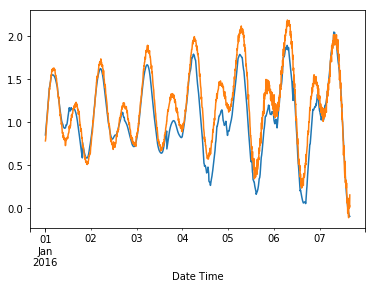

In [47]:
model_objs.iloc[-1,-1].predict(indep_test.index[:1600]).plot()
(indep_test)[:1600].plot()

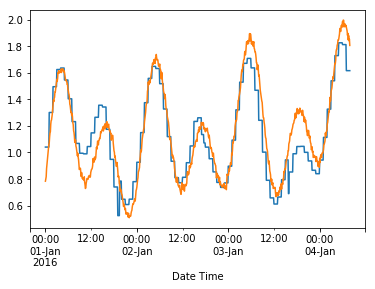

In [41]:
model_objs.iloc[-1,-1].predict(indep_test.index[:800]).plot()
(indep_test)[:800].plot()

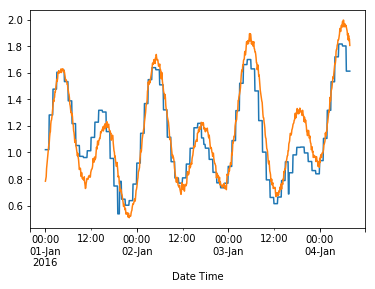

In [36]:
model_objs.iloc[-1,-1].predict(indep_test.index[:800]).plot()
(indep_test)[:800].plot()

In [39]:
# np.random.seed(0)
# indep_test_rmse = pd.DataFrame()
# time_taken_df = pd.DataFrame()

# for data, dataname in [(data_used, '100% data'), 
#                        (data_used[np.random.uniform(size=len(data_used)) < .5], '50% data'),
#                       (data_used[np.random.uniform(size=len(data_used)) < .1], '10% data'),
#                        (data_used[np.random.uniform(size=len(data_used)) < .05], '5% data'),
#                       (data_used[np.random.uniform(size=len(data_used)) < .01], '1% data'),
#                        (data_used[np.random.uniform(size=len(data_used)) < .005], '0.5% data'),
#                       (data_used[np.random.uniform(size=len(data_used)) < .001], '0.1% data'),
#                       #(data_used[np.random.uniform(size=len(data_used)) < .0001], '0.01% data')
#                       ]:
#     for model, modelname in [(constant_model, 'constant'), 
#                              (daily_avg_model, 'hour avg.'),
#                             (annual_avg_model, 'day-of-year avg.'),
#                              (lunar_avg_model, 'moon-phase avg.'),
#                             #(daily_annual_avg_model, 'daily-annual avg.'),
#                             #(daily_annual_bas_model, 'daily-annual bas.'),
#                              (daily_annual_lunar_bas_model, 'daily-annual-lunar bas.')
#                             ]:
#         rmse, time_taken = model(data, indep_test)
#         indep_test_rmse.loc[dataname, modelname] = rmse
#         time_taken_df.loc[dataname, modelname] = time_taken

building reg matrices
building reg matrices
grad of val. cost in the lambdas [ 1008.3850684    104.76892388  1851.25137659]
numerical gradient of val cost in u: [ 2741.07480752   284.79146197  5032.2229769 ]
grad of val. cost in the lambdas [-696.83151114 -508.53459739 -512.67778908]
numerical gradient of val cost in u: [-0.0316361  -0.02308744 -0.02327554]
grad of val. cost in the lambdas [  578.7157722   1158.84655761  2669.00118021]
numerical gradient of val cost in u: [  40.43173854   80.96233639  186.46866574]
grad of val. cost in the lambdas [ 1800.06459717   309.25201664  4213.55478006]
numerical gradient of val cost in u: [ 1480.37645993   254.32943148  3465.23525813]
grad of val. cost in the lambdas [ 1230.25794031   139.35404622  2467.64646268]
numerical gradient of val cost in u: [ 2496.02783151   282.7306099   5006.5226546 ]
grad of val. cost in the lambdas [ 1054.31607004   111.60805606  1977.46935194]
numerical gradient of val cost in u: [ 2692.10862937   284.98191327  50

building reg matrices
building reg matrices
grad of val. cost in the lambdas [  993.52499097    93.09562366  1835.95456629]
numerical gradient of val cost in u: [ 2700.68092907   253.06014209  4990.64193543]
grad of val. cost in the lambdas [-1156549.38101459 -1152127.6839425   -750280.44013626]
numerical gradient of val cost in u: [-52.50726066 -52.30651593 -34.06267928]
grad of val. cost in the lambdas [  288.29598289   977.23022303  2871.37030156]
numerical gradient of val cost in u: [  19.5049705    66.11554722  194.26560321]
grad of val. cost in the lambdas [ 1775.1316729    256.34968977  4236.04800505]
numerical gradient of val cost in u: [ 1442.04978509   208.24878553  3441.20507146]
grad of val. cost in the lambdas [ 1213.78912395   121.5965851   2456.668601  ]
numerical gradient of val cost in u: [ 2453.81287453   245.8213376   4966.43520909]
grad of val. cost in the lambdas [ 1039.14659233    98.81931512  1962.8978263 ]
numerical gradient of val cost in u: [ 2651.26447929   2

building reg matrices
building reg matrices
grad of val. cost in the lambdas [  951.53818783    27.28397821  1769.8119922 ]
numerical gradient of val cost in u: [ 2586.54896507    74.16554217  4810.84777819]
grad of val. cost in the lambdas [-12743815.75523349 -13956976.25273025   2849168.68773431]
numerical gradient of val cost in u: [-578.56834019 -633.64574157  129.3520583 ]
grad of val. cost in the lambdas [-3548.15383929 -4592.33492299  9483.08281172]
numerical gradient of val cost in u: [-188.46031713 -243.92203246  503.69428019]
grad of val. cost in the lambdas [ 1665.52577505  -207.08164859  4600.19646203]
numerical gradient of val cost in u: [ 1229.45365021  -152.86301333  3395.76151664]
grad of val. cost in the lambdas [ 1170.06146579     9.08685089  2448.90246862]
numerical gradient of val cost in u: [ 2296.57717485    17.83551971  4806.66501489]
grad of val. cost in the lambdas [  997.22816963    24.8697422   1907.21073683]
numerical gradient of val cost in u: [ 2527.448471

grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.78640144    74.18603614  4817.16125661]
grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.78642659    74.18603686  4817.16130344]
grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.7864319     74.18603701  4817.16131332]
grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.78643078    74.18603698  4817.16131123]
grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.78642802    74.1860369   4817.16130609]
grad of val. cost in the lambdas [  952.01458913    27.29212453  1772.17400631]
numerical gradient of val cost in u: [ 2587.7864302     74.18603697  4817.16131015]
grad of val. cos

grad of val. cost in the lambdas [ -4.94161534e+01   5.44629268e-01   5.63863620e+02]
numerical gradient of val cost in u: [ -1.79854857  50.47163676  20.52236032]
grad of val. cost in the lambdas [ 1846.14239787    -7.85197586  4590.28045649]
numerical gradient of val cost in u: [ 1191.53587062   -69.21323782  2962.65544111]
grad of val. cost in the lambdas [ 1193.82668963   -42.00957958  2488.52236265]
numerical gradient of val cost in u: [ 2257.83894899  -153.6531528   4706.44756448]
grad of val. cost in the lambdas [  992.37303089   -43.70201446  1859.99021515]
numerical gradient of val cost in u: [ 2496.4748939   -126.56726661  4679.10627403]
grad of val. cost in the lambdas [  952.79657421   -43.54765389  1737.47585798]
numerical gradient of val cost in u: [ 2547.87022315  -119.9727306   4646.1785462 ]
grad of val. cost in the lambdas [  944.60189701   -43.49841058  1712.21751552]
numerical gradient of val cost in u: [ 2558.77429334  -118.57807664  4638.12128389]
grad of val. cos

grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.0305603  -1081.46237369  3184.30935242]
grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.03092964 -1081.46219637  3184.30999055]
grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.03085159 -1081.46223385  3184.3098557 ]
grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.03065934 -1081.46232615  3184.30952353]
grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.03081102 -1081.46225333  3184.3097856 ]
grad of val. cost in the lambdas [  678.02694673  -397.84110328  1171.46595078]
numerical gradient of val cost in u: [ 1843.03071091 -1081.46230139  3184.30961263]
grad of val. cos

grad of val. cost in the lambdas [ -4.46354884e+03   1.23668084e-01  -4.66987043e+03]
numerical gradient of val cost in u: [ -2.02644804e-01   2.72397082e+03  -2.12011790e-01]
grad of val. cost in the lambdas [ -5.31337009e+03  -1.71928567e+00  -1.78256753e+03]
numerical gradient of val cost in u: [-152.34956381 -193.66156417  -51.11132497]
grad of val. cost in the lambdas [ 1488.33028181  -274.80054912  6261.62098873]
numerical gradient of val cost in u: [  883.0915123  -2594.89933565  3715.29385377]
grad of val. cost in the lambdas [  723.65695091  -518.14239089  1169.23791464]
numerical gradient of val cost in u: [ 1486.69356195 -1771.08427783  2402.1029272 ]
grad of val. cost in the lambdas [ 647.32377895 -549.19987437  796.32879123]
numerical gradient of val cost in u: [ 1661.88684984 -1564.32778296  2044.43029799]
grad of val. cost in the lambdas [ 633.00658655 -555.46616625  735.08334482]
numerical gradient of val cost in u: [ 1700.16917053 -1524.8084494   1974.33339113]
grad of

/Users/enzo/anaconda3/envs/pytimeseries-env/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


building reg matrices
building reg matrices
grad of val. cost in the lambdas [ 960.95708138 -746.6718265   -56.92888699]
numerical gradient of val cost in u: [ 2612.15217224 -2029.66445779  -154.74875901]
grad of val. cost in the lambdas [ -4.92953084e+03   7.74377557e-02   1.24800222e-04]
numerical gradient of val cost in u: [ -2.23800354e-01   1.70568008e+03   2.74890782e+00]
grad of val. cost in the lambdas [ -1.31263119e+04  -9.12150766e+00   8.20843113e+00]
numerical gradient of val cost in u: [-491.55491534 -825.82333025  743.15718211]
grad of val. cost in the lambdas [ 1372.73861794  -132.79440207    70.45259594]
numerical gradient of val cost in u: [  835.60274339 -1227.99408717   651.49863163]
grad of val. cost in the lambdas [ 1399.00854074  -520.00345969    -2.57777675]
numerical gradient of val cost in u: [ 2473.59925844 -2009.67217557    -9.96240718]
grad of val. cost in the lambdas [ 1054.11032351  -697.23611895   -43.38999335]
numerical gradient of val cost in u: [ 2610.

grad of val. cost in the lambdas [ 970.52217379 -738.77718182  -51.11298971]
numerical gradient of val cost in u: [ 2635.99918663 -2009.24732889  -139.01330207]
grad of val. cost in the lambdas [ 970.30879658 -738.74227861  -50.99360244]
numerical gradient of val cost in u: [ 2636.88605334 -2008.44463846  -138.6386123 ]
grad of val. cost in the lambdas [ 970.30879658 -738.74227861  -50.99360244]
numerical gradient of val cost in u: [ 2637.19605967 -2008.29509615  -138.62805023]
grad of val. cost in the lambdas [ 970.30879658 -738.74227861  -50.99360244]
numerical gradient of val cost in u: [ 2637.26157826 -2008.26349466  -138.62581824]
grad of val. cost in the lambdas [ 970.30879658 -738.74227861  -50.99360244]
numerical gradient of val cost in u: [ 2637.27542423 -2008.25681652  -138.62534657]
grad of val. cost in the lambdas [ 970.30879658 -738.74227861  -50.99360244]
numerical gradient of val cost in u: [ 2637.27835023 -2008.25540526  -138.62524689]
grad of val. cost in the lambdas [

In [40]:
indep_test_rmse

,constant,hour avg.,day-of-year avg.,moon-phase avg.,daily-annual-lunar bas.
100% data,0.523762,0.426922,0.521994,0.523775,0.217384
50% data,0.523755,0.426910,0.521999,0.523756,0.197847
10% data,0.523737,0.426903,0.522518,0.523710,0.210679
5% data,0.523583,0.426608,0.522946,0.523779,0.187584
1% data,0.523948,0.427620,0.526564,0.524187,0.199999
0.5% data,0.523818,0.427184,0.532525,0.524186,0.207411
0.1% data,0.524319,0.430235,0.591547,0.525217,0.447327


In [44]:
print(indep_test_rmse.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  constant &  hour avg. &  day-of-year avg. &  moon-phase avg. &  daily-annual-lunar bas. \\
\midrule
100\% data &     0.524 &      0.427 &             0.522 &            0.524 &                    0.217 \\
50\% data  &     0.524 &      0.427 &             0.522 &            0.524 &                    0.198 \\
10\% data  &     0.524 &      0.427 &             0.523 &            0.524 &                    0.211 \\
5\% data   &     0.524 &      0.427 &             0.523 &            0.524 &                    0.188 \\
1\% data   &     0.524 &      0.428 &             0.527 &            0.524 &                    0.200 \\
0.5\% data &     0.524 &      0.427 &             0.533 &            0.524 &                    0.207 \\
0.1\% data &     0.524 &      0.430 &             0.592 &            0.525 &                    0.447 \\
\bottomrule
\end{tabular}



In [41]:
time_taken_df

,constant,hour avg.,day-of-year avg.,moon-phase avg.,daily-annual-lunar bas.
100% data,0.009809,0.513996,0.551419,35.069983,50.859498
50% data,0.006082,0.177334,0.092707,16.744654,28.960981
10% data,0.001393,0.024293,0.017909,3.730775,17.021848
5% data,0.000462,0.012715,0.010813,1.672185,27.393003
1% data,0.000214,0.004275,0.003301,0.383208,31.597503
0.5% data,0.000171,0.003501,0.002222,0.172919,25.350114
0.1% data,0.000145,0.002681,0.001707,0.042810,19.865539


## Prediction on 1% data

In [35]:
np.random.seed(0)
mask = np.random.uniform(size=len(data_used)) < .01
small_data = data_used[mask]

baseline = npts.Baseline(npts.HourOfDay(),#lambdas=np.logspace(-6,2, 5)),
                          npts.DayOfYear(),#lambdas=np.logspace(-6,2, 5)),
                         npts.LunarPhase(n_periods=16))#,lambdas=np.logspace(-6,2, 5)))

baseline.fit(small_data)

building reg matrices
grad of val. cost in the lambdas [  685.04341293  -403.1456201   1157.74623952]
numerical gradient of val cost in u: [ 1862.14106106 -1095.86341334  3147.08056484]
grad of val. cost in the lambdas [ -1.42297425e+03   1.28606760e-01  -1.61664181e+03]
numerical gradient of val cost in u: [ -6.46029310e-02   2.83275241e+03  -7.33954248e-02]
grad of val. cost in the lambdas [ -1.82121111e+03  -1.62474636e+00   5.85250719e+01]
numerical gradient of val cost in u: [ -59.05337488 -165.4928317     1.89769488]
grad of val. cost in the lambdas [ 1600.09426704  -180.50024466  5686.83247227]
numerical gradient of val cost in u: [ 1005.74015683 -1625.91744117  3574.46176789]
grad of val. cost in the lambdas [  810.44806828  -376.16410503  1773.93410128]
numerical gradient of val cost in u: [ 1617.52335202 -1316.5779062   3540.48574618]
grad of val. cost in the lambdas [  708.24722625  -398.18313745  1267.7643514 ]
numerical gradient of val cost in u: [ 1806.23757701 -1140.3670

grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150113 -1093.85525848  3154.63555456]
grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150459 -1093.85525682  3154.63556041]
grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150385 -1093.85525717  3154.63555917]
grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150206 -1093.85525803  3154.63555613]
grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150347 -1093.85525735  3154.63555853]
grad of val. cost in the lambdas [  685.53192244  -402.40024154  1160.54889863]
numerical gradient of val cost in u: [ 1863.43150254 -1093.8552578   3154.63555694]
grad of val. cos

In [37]:
print('data size', len(small_data))
print('model size', len(baseline.theta))

data size 17388
model size 140544


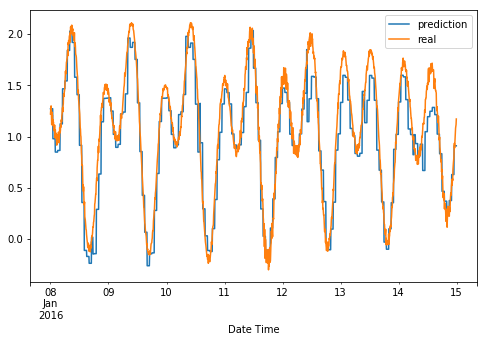

In [42]:
poll = 240*7
win_len = 240*7
window = indep_test[poll:poll+win_len]
plt.figure(figsize=(8,5))
baseline.predict(window.index).plot(label='prediction' )
window.plot(label='real')
import matplotlib.pyplot as plt
plt.legend()
plt.savefig('../../non_par_ts/tides_prediction.pdf')

## Baseline 

In [7]:
# import datetime

# class LunarPhase(npts.features.Feature):

#     def __init__(self, n_periods = 8, **kwargs):
#         super().__init__(**kwargs)
#         self.n_periods = n_periods
        
#     def lunations(self, timestamp): 
#         """Lunations since Jan 1, 2001."""
#         diff = timestamp - datetime.datetime(2001, 1, 1)
#         days = diff.days + diff.seconds / 86400
#         return 0.20439731 + days * 0.03386319269

#     def indexer(self, index, column=None):
#         lunations = self.lunations(index)
#         return (np.floor(self.n_periods*lunations + .5).astype(int) % self.n_periods)

In [8]:
test = water_level[-len(water_level)//20:]
train = water_level[:-len(water_level)//20]

In [9]:
train = water_level[:len(train)//6]

In [11]:
baseline = npts.Baseline(npts.IntervalOfDay('6min'),#, lambdas=np.logspace(-5,-2, 5)), 
                         npts.MonthOfYear(),##lambdas=np.logspace(-9,-2, 5)), 
                         npts.LunarPhase(n_periods=48))#, lambdas=np.logspace(-8,-2, 5)))#np.logspace(-22,-18, 4)))

Building baseline with 138240 =  240*12*48 values.
building reg matrices


In [12]:
baseline.fit(train, compute_tr_costs=True)

Fitting on 303579 observations, of dimension 1
Train set: 242951 obs. Test set : 60628 obs.
Making quadratic loss term for 242951 obs.
Making quadratic loss term for 60628 obs.
Provided lambdas: [[None], [None], [None]]
working with lambda (None, None, None)
numerically optimizing on 3 dims
solving with λ=(1.0000072338224604, 1.0000072338224604, 1.0000072338224604)
mat [[ 6.00005164 -1.00000723  0.          0.          0.        ]
 [-1.00000723  6.00005164 -1.00000723  0.          0.        ]
 [ 0.         -1.00000723  6.00005575 -1.00000723  0.        ]
 [ 0.          0.         -1.00000723  6.00005575 -1.00000723]
 [ 0.          0.          0.         -1.00000723  6.00005164]]
rhs [[  1.21423662e-05]
 [  1.09281295e-05]
 [  1.73491774e-05]
 [  1.70322411e-05]
 [  1.19118670e-05]]
CG took 0.9890172481536865 seconds.
(60628, 1)
(242951, 1)
Val. cost: 2.815e-01
computing gradient of test cost in the lambdas
CG took 0.8605420589447021 seconds.
grad of val. cost in the lambdas [  6.274371

CG took 0.004644870758056641 seconds.
grad of val. cost in the lambdas [  6.27437109e-05   4.33471328e-06   3.18413700e-05]
numerical gradient of val cost in u: [  6.27441648e-05   4.33474463e-06   3.18416003e-05]
solving with λ=(1.0000072334471442, 1.0000072337965311, 1.0000072336319938)
mat [[ 6.00005163 -1.00000723  0.          0.          0.        ]
 [-1.00000723  6.00005163 -1.00000723  0.          0.        ]
 [ 0.         -1.00000723  6.00005575 -1.00000723  0.        ]
 [ 0.          0.         -1.00000723  6.00005575 -1.00000723]
 [ 0.          0.          0.         -1.00000723  6.00005163]]
rhs [[  1.21423662e-05]
 [  1.09281295e-05]
 [  1.73491774e-05]
 [  1.70322411e-05]
 [  1.19118670e-05]]
CG took 0.004655122756958008 seconds.
(60628, 1)
(242951, 1)
Val. cost: 2.815e-01
computing gradient of test cost in the lambdas
CG took 0.0037560462951660156 seconds.
grad of val. cost in the lambdas [  6.27437109e-05   4.33471328e-06   3.18413700e-05]
numerical gradient of val cost 

In [13]:
# baseline.val_costs

In [19]:
import matplotlib.pyplot as plt
def plot_RMSE(baseline):
    ref = ['intraday', 'day', 'moonphase']
    for pat in [[0,1], [0,2], [1,2]]:
        for cost_dict, title in [[baseline.val_costs, 'test'], 
                                 [baseline.tr_costs, 'train']]:
            fig = plt.figure(figsize=(8,4))
            cax = plt.hexbin(*np.array([[*(np.log10(k)[pat]), np.sqrt(v)] for k, v 
                                  in cost_dict.items()]).T,
                      gridsize=5)
            axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
            plt.plot(*np.log10(baseline.best_lambda)[pat], 'ro', markersize=10)
            plt.xlabel(f'log10(λ_{ref[pat[0]]})')
            plt.ylabel(f'log10(λ_{ref[pat[1]]})')
            plt.title(title)
    
plot_RMSE(baseline)

NameError: name 'baseline' is not defined

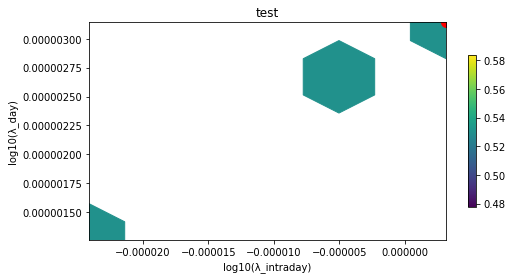

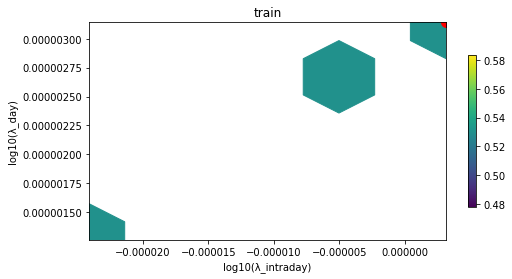

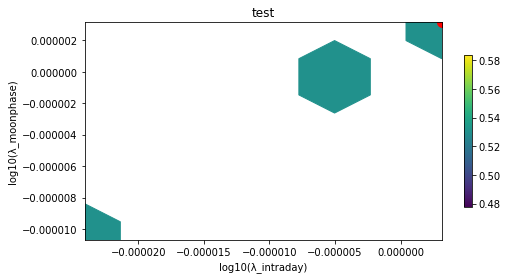

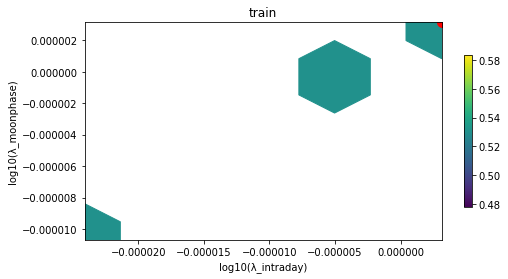

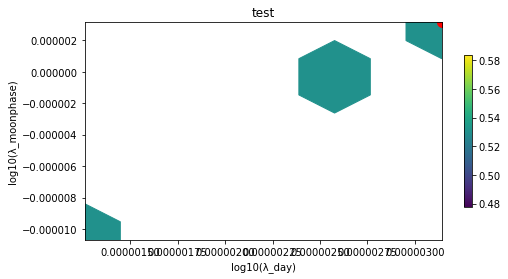

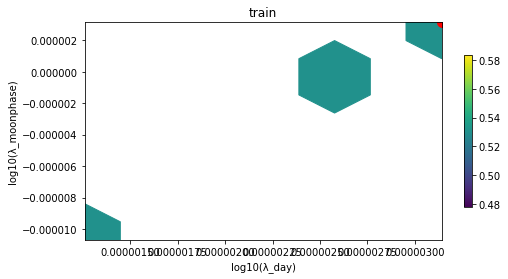

In [15]:
import matplotlib.pyplot as plt
def plot_RMSE(baseline):
    ref = ['intraday', 'day', 'moonphase']
    for pat in [[0,1], [0,2], [1,2]]:
        for cost_dict, title in [[baseline.val_costs, 'test'], 
                                 [baseline.tr_costs, 'train']]:
            fig = plt.figure(figsize=(8,4))
            cax = plt.hexbin(*np.array([[*(np.log10(k)[pat]), np.sqrt(v)] for k, v 
                                  in cost_dict.items()]).T,
                      gridsize=5)
            axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
            plt.plot(*np.log10(baseline.best_lambda)[pat], 'ro', markersize=10)
            plt.xlabel(f'log10(λ_{ref[pat[0]]})')
            plt.ylabel(f'log10(λ_{ref[pat[1]]})')
            plt.title(title)
    
plot_RMSE(baseline)

Text(0,0.5,'moonphase')

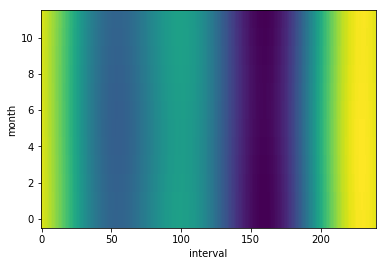

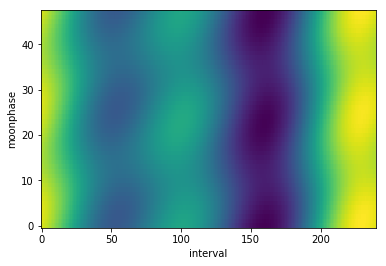

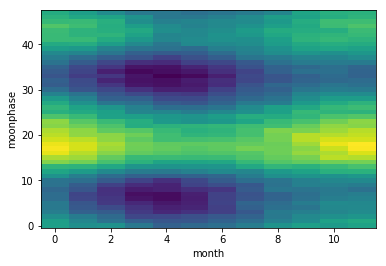

In [16]:
plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),0), origin='lower', aspect='auto')
plt.ylabel('month')
plt.xlabel('interval')


plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),1), origin='lower', aspect='auto')
plt.ylabel('moonphase')
plt.xlabel('interval')

plt.figure()
plt.imshow(np.median(baseline.theta.reshape(*reversed(baseline.n_periods)),2), origin='lower', aspect='auto')
plt.xlabel('month')
plt.ylabel('moonphase')

## Experiments 

In [27]:
import scipy.sparse as sp
import numpy as np

In [32]:
a = np.arange(1000.)
b = np.arange(1000.)

In [33]:
%timeit a*b

960 ns ± 50.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [38]:
%timeit sp.diags(a)@b

65.3 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [40]:
%timeit c = np.array(a)

593 ns ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [41]:
%timeit c = np.array(a, copy=False)

166 ns ± 4.21 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [42]:
d = np.array([1,2])

In [43]:
%timeit e = np.array(d)

408 ns ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [44]:
%timeit e = np.array(d, copy=False)

155 ns ± 2.16 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [45]:
%timeit e = d

22.2 ns ± 0.931 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
